[[0.39 0.  ]
 [0.95 1.  ]
 [0.52 1.  ]
 ...
 [0.26 0.  ]
 [0.87 1.  ]
 [0.51 0.  ]]
327.8202349127406
0.14680709131784173


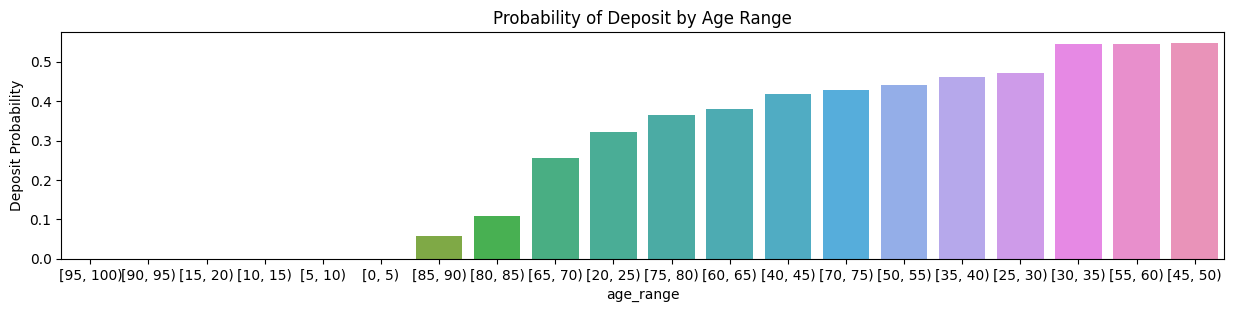

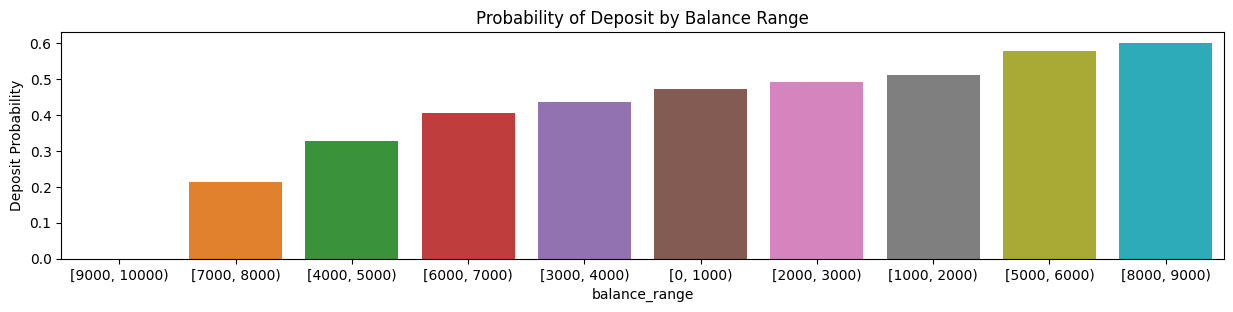

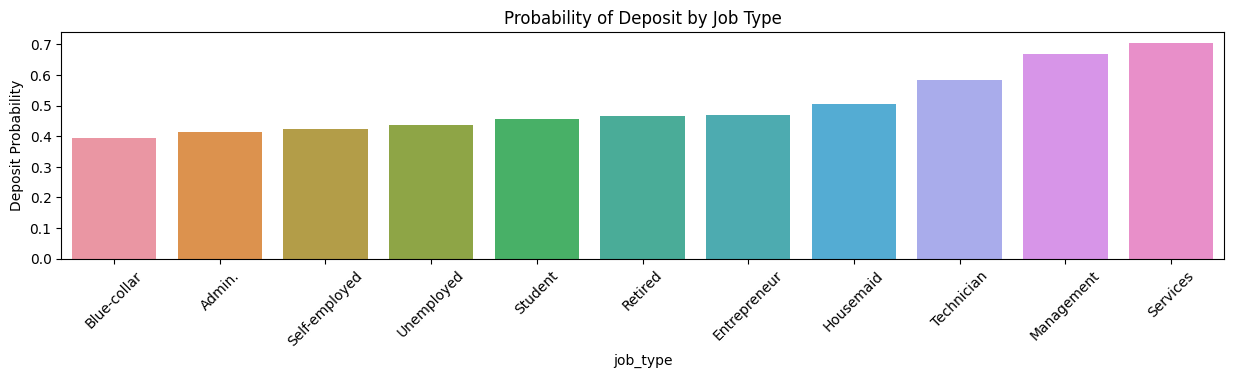

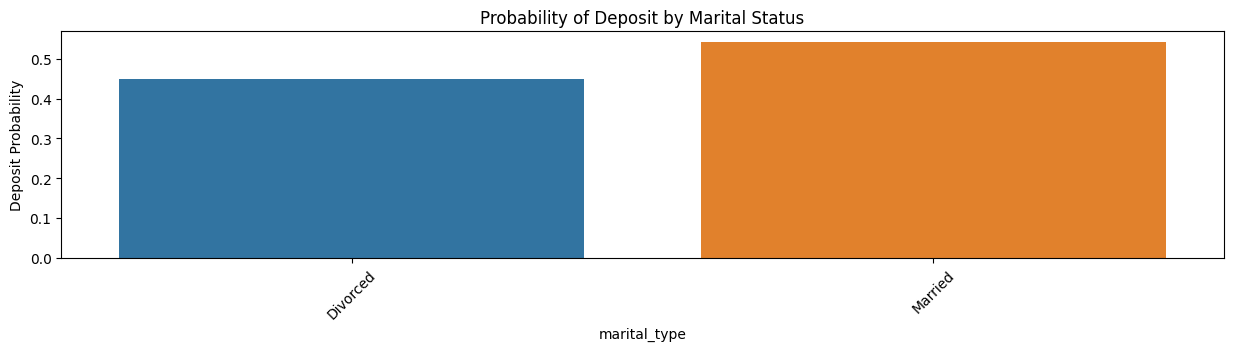

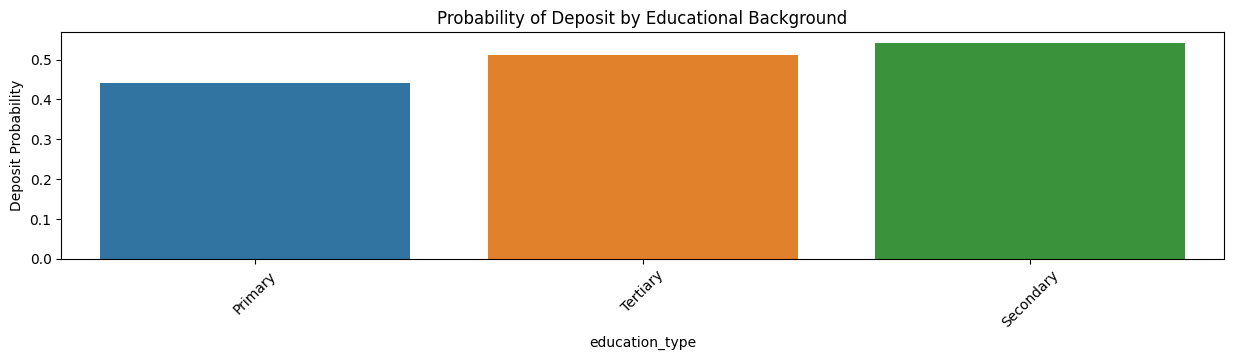

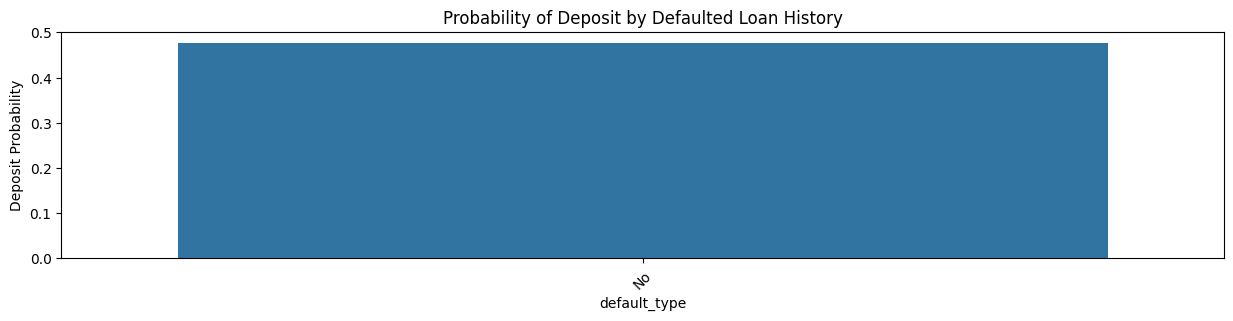

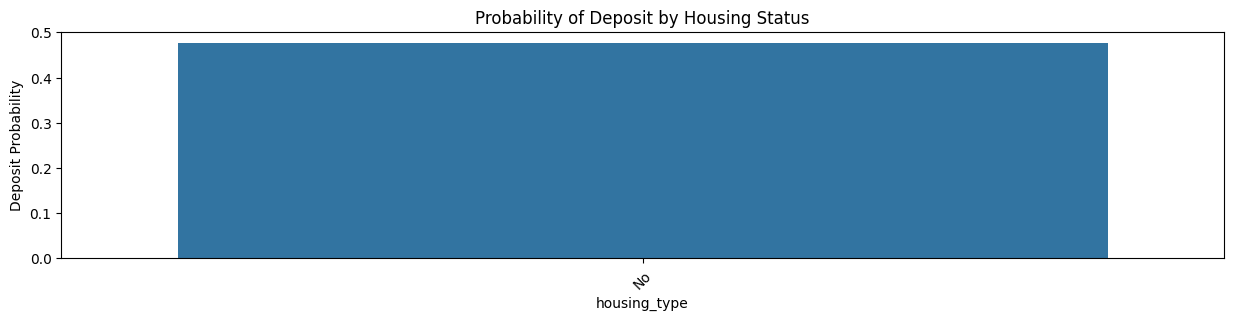

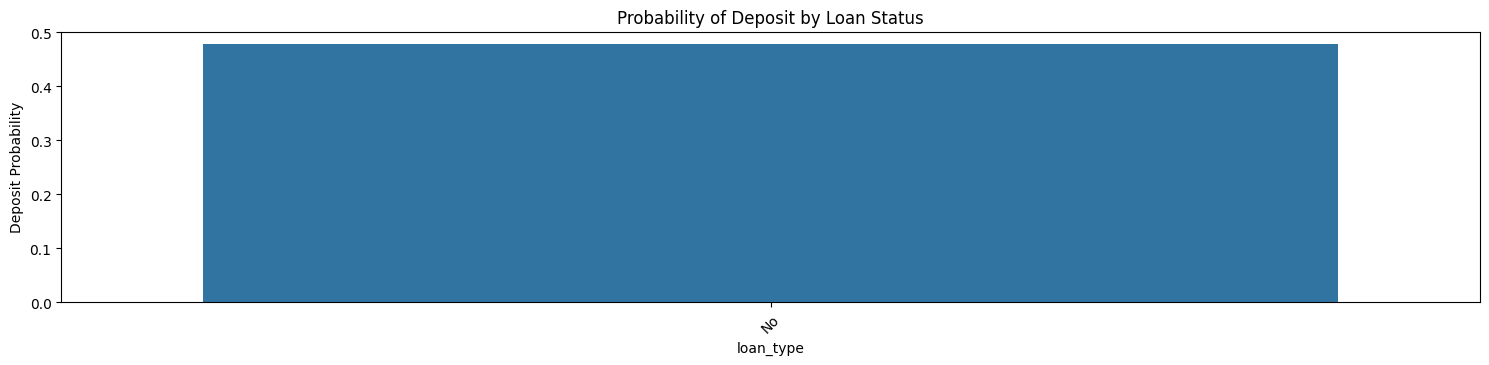



Customer segment with highest probability of depositing:
Age Range                     [25, 30)
Balance Range             [2000, 3000)
Job                            Student
Marital Status                Divorced
education_type                 Primary
Has Defaulted Loan                  No
Has Housing                         No
Has Loan                            No
Deposit Probability           1.487013
No Deposit Probability        0.487013
Name: 3480, dtype: object


In [ ]:
# import the required modules
import pandas as pd                 # for data analysis / data structure
import seaborn as sb                # for data visualization
import matplotlib.pyplot as plt     # for plotting the confusion matrix
import numpy as np

# Scikit-Learn libraries
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Load and read dataset (df = dataframe)
df = pd.read_csv("bank.csv")

# Pre-processing of data
df = df.dropna()                    # remove null values
df = df.drop_duplicates()           # remove duplicate values

# Sort columns in ascending order
sorted_cols = df.columns.sort_values()

# Encode the categorical variables
df_encoded = pd.get_dummies(df, columns=["job", "marital", "education", "default", "housing", "loan", "contact", "month", "poutcome", "deposit"], 
                                prefix=["job", "marital", "education", "default", "housing", "loan", "contact", "month", "poutcome", "deposit"], drop_first=True)

# Split the data into training and testing sets
X = df_encoded.drop("deposit_yes", axis=1)
y = df_encoded["deposit_yes"]
Xn = df_encoded.iloc[:, :-1].values # numpy version
yn = df_encoded.iloc[:, -1].values  # numpy version

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
Xn_train, Xn_test, yn_train, yn_test = train_test_split(Xn, yn, test_size=0.2, random_state=42)

# Scale the numerical variables
scaler = StandardScaler()                         # create a StandardScaler object (for transforming data)
X_train_scaled = scaler.fit_transform(X_train)    # scale training set  (fit transform -> mean, standard deviation)
X_test_scaled = scaler.transform(X_test)          # scale testing set (transform -> apply the scaling transformation to X_test)

# Train the Linear Regression model on the training set
regressor = LinearRegression()
regressor.fit(X_train_scaled, y_train)

# Make predictions on the testing set
y_pred = regressor.predict(X_test_scaled)

# Display comparison of prediction and real answer
np.set_printoptions(precision=2)
comparison = np.concatenate((y_pred.reshape(len(y_pred),1), yn_test.reshape(len(yn_test),1)),1)
print(comparison)

# Sum of Squared Error (SSE) to measure the performance of the algorithm.
squared_errors = (y_test - y_pred) ** 2
sse = np.sum(squared_errors)
print(sse)

# Calculating the MSE with sklearn
# The mean squared error (MSE) tells you how close a regression line is to a set of points.
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print(mse)

# To better answer the Problem Statement: Which customer segment has the highest chance of depositing?
# Predict probabilities on the testing set
no_deposit = abs(1-y_pred)
y_probability = np.concatenate((no_deposit.reshape(len(no_deposit),1), y_pred.reshape(len(y_pred),1)),1)

# Create new dataframe with the probabilities and the original data
probability_df = pd.DataFrame(y_probability, columns=["No Deposit Probability", "Deposit Probability"])
probability_df["age_range"] = pd.cut(X_test["age"], bins=range(0, 101, 5), right=False)
probability_df["balance_range"] = pd.cut(X_test["balance"], bins=range(0, 10001, 1000), right=False)

# Equivalence of data header values and title
job_type_map = {0: "Admin.", 1: "Blue-collar", 2: "Entrepreneur", 3: "Housemaid", 4: "Management", 5: "Retired", 6: "Self-employed", 7: "Services", 8: "Student", 9: "Technician", 10: "Unemployed", 11:"Unknown"}
marital_type_map = {0: "Divorced", 1:"Married", 2:"Single"}
education_type_map = {0: "Primary", 1:"Secondary", 2:"Tertiary", 3:"Unknown"}
default_type_map = {0:"No", 1:"Yes"}
housing_type_map = {0:"No", 1:"Yes"}
loan_type_map = {0:"No", 1:"Yes"}

# Extract the specific category under each main category
job_cols = [col for col in X_test.columns if col.startswith("job_")]
job_prefix = np.argmax(X_test[job_cols].values, axis=1)
probability_df["job_type"] = pd.Series(job_prefix).map(job_type_map)

marital_cols = [col for col in X_test.columns if col.startswith("marital_")]
marital_prefix = np.argmax(X_test[marital_cols].values, axis=1)
probability_df["marital_type"] = pd.Series(marital_prefix).map(marital_type_map)

education_cols = [col for col in X_test.columns if col.startswith("education_")]
education_prefix = np.argmax(X_test[education_cols].values, axis=1)
probability_df["education_type"] = pd.Series(education_prefix).map(education_type_map)

default_cols = [col for col in X_test.columns if col.startswith("default_")]
default_prefix = np.argmax(X_test[default_cols].values, axis=1)
probability_df["default_type"] = pd.Series(default_prefix).map(default_type_map)

housing_cols = [col for col in X_test.columns if col.startswith("housing_")]
housing_prefix = np.argmax(X_test[housing_cols].values, axis=1)
probability_df["housing_type"] = pd.Series(housing_prefix).map(housing_type_map)

loan_cols = [col for col in X_test.columns if col.startswith("loan_")]
loan_prefix = np.argmax(X_test[loan_cols].values, axis=1)
probability_df["loan_type"] = pd.Series(loan_prefix).map(loan_type_map)

# For determining the specific customer group with the highest probability of depositing
prob_df_grouped = probability_df.groupby(["age_range", "balance_range", "job_type", "marital_type", "education_type", "default_type", "housing_type", "loan_type"]).agg({"Deposit Probability": "mean", "No Deposit Probability": "mean"}).reset_index()

# Rename the columns to make it more easily understandable
prob_df_grouped = prob_df_grouped.rename(columns={
    "age_range": "Age Range",
    "balance_range": "Balance Range",
    "job_type": "Job",
    "marital_type": "Marital Status",
    "educational_type": "Educational Background",
    "default_type": "Has Defaulted Loan",
    "housing_type": "Has Housing",
    "loan_type": "Has Loan"
})

# Group each subcategories into their respective main category for use in displaying the probability of depositing of each category in visualization form
prob_df_age_grouped = probability_df.groupby(["age_range"]).agg({"Deposit Probability": "mean", "No Deposit Probability": "mean"}).reset_index()
prob_df_balance_grouped = probability_df.groupby(["balance_range"]).agg({"Deposit Probability": "mean", "No Deposit Probability": "mean"}).reset_index()
prob_df_job_type_grouped = probability_df.groupby(["job_type"]).agg({"Deposit Probability": "mean", "No Deposit Probability": "mean"}).reset_index()
prob_df_marital_type_grouped = probability_df.groupby(["marital_type"]).agg({"Deposit Probability": "mean", "No Deposit Probability": "mean"}).reset_index()
prob_df_education_type_grouped = probability_df.groupby(["education_type"]).agg({"Deposit Probability": "mean", "No Deposit Probability": "mean"}).reset_index()
prob_df_default_type_grouped = probability_df.groupby(["default_type"]).agg({"Deposit Probability": "mean", "No Deposit Probability": "mean"}).reset_index()
prob_df_housing_type_grouped = probability_df.groupby(["housing_type"]).agg({"Deposit Probability": "mean", "No Deposit Probability": "mean"}).reset_index()
prob_df_loan_type_grouped = probability_df.groupby(["loan_type"]).agg({"Deposit Probability": "mean", "No Deposit Probability": "mean"}).reset_index()

# Sort the data by prbability of depositing, in ascending order
prob_df_sorted = prob_df_grouped.sort_values(by="Deposit Probability", ascending=False)

prob_df_age_sorted = prob_df_age_grouped.sort_values(by="Deposit Probability", ascending=False)
prob_df_balance_sorted = prob_df_balance_grouped.sort_values(by="Deposit Probability", ascending=False)
prob_df_job_sorted = prob_df_job_type_grouped.sort_values(by="Deposit Probability", ascending=False)
prob_df_marital_sorted = prob_df_marital_type_grouped.sort_values(by="Deposit Probability", ascending=False)
prob_df_education_sorted = prob_df_education_type_grouped.sort_values(by="Deposit Probability", ascending=False)
prob_df_default_sorted = prob_df_default_type_grouped.sort_values(by="Deposit Probability", ascending=False)
prob_df_housing_sorted = prob_df_housing_type_grouped.sort_values(by="Deposit Probability", ascending=False)
prob_df_loan_sorted = prob_df_loan_type_grouped.sort_values(by="Deposit Probability", ascending=False)

# Plot the probabilities by age range
plt.figure(figsize=(15,10))

plt.subplot(3, 1, 1)
sb.barplot(x="age_range", y="Deposit Probability", data=prob_df_age_sorted, order=prob_df_age_sorted['age_range'].tolist()[::-1], errorbar=None)
plt.title("Probability of Deposit by Age Range")

# Plot the probabilities by balance range
plt.figure(figsize=(15,10))

plt.subplot(3, 1, 1)
sb.barplot(x="balance_range", y="Deposit Probability", data=prob_df_balance_sorted, order=prob_df_balance_sorted['balance_range'].tolist()[::-1], errorbar=None)
plt.title("Probability of Deposit by Balance Range")

# Plot the probabilities by job type
plt.figure(figsize=(15,10))

plt.subplot(3, 1, 1)
sb.barplot(x="job_type", y="Deposit Probability", data=prob_df_job_sorted, order=prob_df_job_sorted['job_type'].tolist()[::-1], errorbar=None)
plt.title("Probability of Deposit by Job Type")
plt.xticks(rotation=45)

# Plot the probabilities by marital status
plt.figure(figsize=(15,10))

plt.subplot(3, 1, 1)
sb.barplot(x="marital_type", y="Deposit Probability", data=prob_df_marital_sorted, order=prob_df_marital_sorted['marital_type'].tolist()[::-1], errorbar=None)
plt.title("Probability of Deposit by Marital Status")
plt.xticks(rotation=45)

# Plot the probabilities by educational background
plt.figure(figsize=(15,10))

plt.subplot(3, 1, 1)
sb.barplot(x="education_type", y="Deposit Probability", data=prob_df_education_sorted, order=prob_df_education_sorted['education_type'].tolist()[::-1], errorbar=None)
plt.title("Probability of Deposit by Educational Background")
plt.xticks(rotation=45)

# Plot the probabilities by defaulted loan status (has defaulted loan?)
plt.figure(figsize=(15,10))

plt.subplot(3, 1, 1)
sb.barplot(x="default_type", y="Deposit Probability", data=prob_df_default_sorted, order=prob_df_default_sorted['default_type'].tolist()[::-1], errorbar=None)
plt.title("Probability of Deposit by Defaulted Loan History")
plt.xticks(rotation=45)

# Plot the probabilities by housing status (has housing?)
plt.figure(figsize=(15,10))

plt.subplot(3, 1, 1)
sb.barplot(x="housing_type", y="Deposit Probability", data=prob_df_housing_sorted, order=prob_df_housing_sorted['housing_type'].tolist()[::-1], errorbar=None)
plt.title("Probability of Deposit by Housing Status")
plt.xticks(rotation=45)

# Plot the probabilities by loan status (has loan?)
plt.figure(figsize=(15,10))

plt.subplot(3, 1, 1)
sb.barplot(x="loan_type", y="Deposit Probability", data=prob_df_loan_sorted, order=prob_df_loan_sorted['loan_type'].tolist()[::-1], errorbar=None)
plt.title("Probability of Deposit by Loan Status")
plt.xticks(rotation=45)

# display
plt.tight_layout()         # for adjusting the spacing between subplots
plt.show()                 # for displaying the figures

# Display the specific customer segment that has the highest probability of depositing
print("\n\nCustomer segment with highest probability of depositing:")
print(prob_df_sorted.iloc[0, :])
